Import standard Python modules

In [63]:
import numpy as np
import pandas as pd
import sys

Import custom uncertainty modules (note that here you will have to amend to the path containing the modules on your own system)

In [64]:
sys.path.append('/home/unimelb.edu.au/imchugh/Code/Python/Py2_7/OzFlux_Uncert')
import random_error as re
import model_error as me

Set some basic configurations, including:

1) data_path: path to data source, which will also need to be amended to reflect your system directory structure

2) n_iterations: the number of iterations to run (this is a Monte Carlo-style simulation, in which we use individual random data draws to test statistical behaviour of the system)

3) scaling_param: a parameter that allows us to calculate sums in gC m-2 per unit time (e.g. per annum) from a per-second and per-mole flux average.

In [65]:
data_path = '/home/unimelb.edu.au/imchugh/Downloads/Advanced_processed_data_HowardSprings_v13a.df'
n_iterations = 100
scaling_param = 1800*10**-6*44

Now:

1) read in the data source, in this case a pickled pandas dataframe (note again that you will need to amend this to your own path)

2) screen data that is below the u* threshold (for BOTH day and night)

In [66]:
df = pd.read_pickle(data_path)
df.Fc.where(df.ustar>df.ustar_used, inplace=True)

Make two sets of dictionaries:

1) a set to tell the scripts the names of the required variables in the data source

2) a set to hold the results of the analysis for each individual year

In [67]:
re_names_dict = {'flux_name': 'Fc',
                 'mean_flux_name': 'Fc_NN',
                 'windspeed_name': 'Ws',
                 'temperature_name': 'Ta',
                 'insolation_name': 'Fsd'}
me_names_dict = {'Observations': 'Fc', 'Model': 'Fc_NN'}
re_results_dict, me_results_dict = {}, {}

A word on how the modules work. 

First random error. We create an instance of a class, which is just to say that we create an object that we can interrogate in ways defined by the underlying code. The things we can do with it are called methods. Let's generate a single instance of the random error class using all of the data.

In [68]:
re_class = re.random_error(df, names_dict=re_names_dict, scaling_coefficient=scaling_param)

We can plot random error as a function of flux magnitude - remember, the average error will be close to zero, 
but the deviation of an instantaneous error from zero will have a statistical average too i.e. an average
deviation from zero. The random error in flux data is heteroschedatic, which means that it changes (increases) as a function of flux magnitude. So let's plot it.

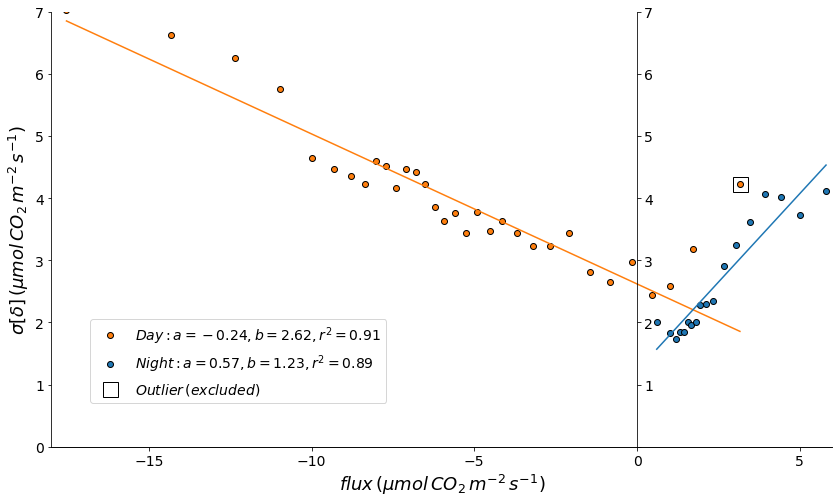

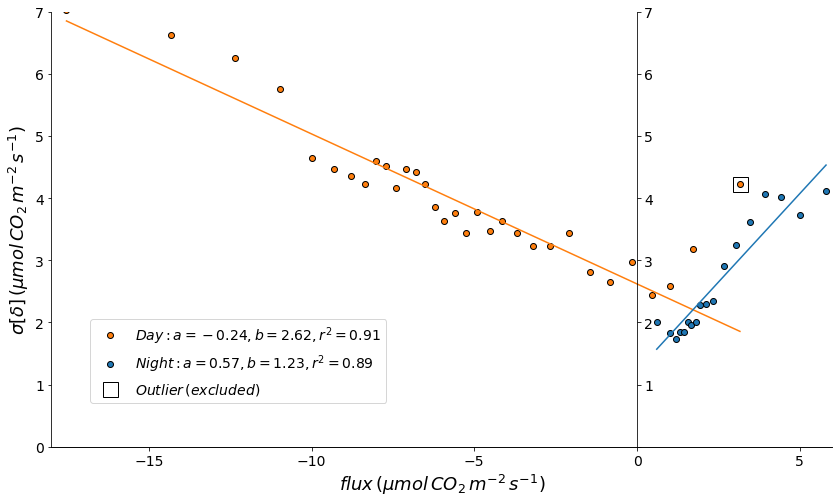

In [69]:
re_class.plot_sigma_delta()

Also, the error is not normally distributed - it follows a double-exponential or Laplacian distribution.
So we need to draw randomly from a Laplacian distribution when generating a single realisation of random error.

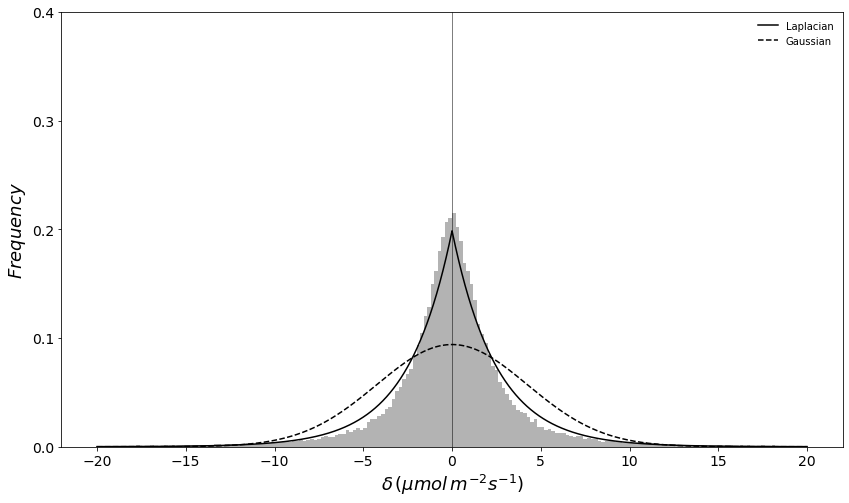

In [70]:
re_class.plot_histogram()

We can get a single realisation (i.e. a time series with valid values for all cases with valid data) 
of random error like this: 

In [71]:
re_class.estimate_random_error()

DT
2001-08-07 15:30:00         NaN
2001-08-07 16:00:00         NaN
2001-08-07 16:30:00         NaN
2001-08-07 17:00:00         NaN
2001-08-07 17:30:00         NaN
                         ...   
2019-11-16 14:00:00   -2.772891
2019-11-16 14:30:00   -0.110154
2019-11-16 15:00:00    1.887326
2019-11-16 15:30:00    0.392709
2019-11-16 16:00:00   -2.779219
Freq: 30T, Length: 320402, dtype: float64

... but that isnt so useful on its own (though you can superimpose that time series onto a model estimate of Fc 
and compare the apparent noise level of true signal and degraded model signal). Let's do n iterations of that and then calculate statistics to see how much variation there is in different iterations of random error generation.
That will return an estimate of the 95% confidence interval of the sums of all those trials - essentially an estimate of the uncertainty imposed on the measured time series by random error in the measurements.  

In [72]:
re_class.propagate_random_error(n_trials=1000)

242.14

There are a bunch of other methods you can call. Just type the name of your class instance then '.' then hit tab - this will give you a list of all available methods and attributes.

Now model error. This is both simpler AND more problematic. All we do for model error is:

1) analyse the proportion of missing data for the passed time series.

2) create a random subset of the data (generally 1000 records)

3) randomly remove the same proportion as calculated in step 1 

4) calculate the difference between the complete 1000-record series, and the same series with artifical gaps introduced and then filled with model values.

5) Calculate the percentage difference between the two series

6) Do this 1000 times, then calculate the 95% CI of the percentages

7) Impose the percentage on the model_filled sum of the original time series

The main problem with this method is that it almost certainly underestimates model error. This is because the model may do a much worse job or predicting the fluxes under extreme conditions where the original fluxes have been rejected. So we are training the model under ideal conditions, and then IMPLICITLY assuming its performance under the conditions for which we have no data would be the same. It manifestly would not be. Caveat emptor!

So, all of that said, we want to do the analysis for each year. Steps:

1) Create a list of all available years in the dataframe, and use this as an iterator for the analysis. For each iteration:

2) Subset a dataframe for the current year from the full dataframe

3) Create an instance of the random error class (re_class) and model error class (me_class).

4) Use the 'propagate_<>_error()' method to extract estimates of uncertainty. 

In [73]:
years_list = [str(x) for x in df.index.year.unique()]
for this_year in years_list:

    this_df = df.loc[this_year]
    
    re_class = re.random_error(this_df, names_dict=re_names_dict,
                               scaling_coefficient=scaling_param)
    re_results_dict[this_year] = re_class.propagate_random_error(n_trials=n_iterations)

    me_class = me.model_error(this_df, names_dict=me_names_dict,
                              scaling_coefficient=scaling_param)
    me_results_dict[this_year] = me_class.propagate_model_error(n_trials=n_iterations)    

Now we sum the results in quadrature to get an estimate of summed uncertainty:

In [74]:
combined_results_dict = {year: np.sqrt(re_results_dict[year]**2 + me_results_dict[year]**2) for year in years_list}

Display result (units are gC m-2 a-1)

In [75]:
combined_results_dict

{'2001': 44.81392130096031,
 '2002': 58.13232356738481,
 '2003': 71.49450274753927,
 '2004': 37.39398864369797,
 '2005': 47.68567620274769,
 '2006': 39.267373929085394,
 '2007': 33.58189013327662,
 '2008': 50.549646367336976,
 '2009': 53.49988844021012,
 '2010': 64.23069741049007,
 '2011': 53.09897801071479,
 '2012': 56.809833720589545,
 '2013': 52.386614633691096,
 '2014': 67.05678727066866,
 '2015': 68.20342038457835,
 '2016': 72.4059451633259,
 '2017': 65.93710339131515,
 '2018': 80.49054597292674,
 '2019': 53.593817638565234}

All done!